In [1]:
import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr

# import rioxarray as rxr
import matplotlib.pyplot as plt

import importlib
import convlstm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-05-16 14:09:15.590937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
importlib.reload(convlstm)

<module 'convlstm' from '/Users/kyla/Desktop/nn/convlstm/ndvi/ConvLSTM_NDVI_Repo-main/kyla_implementation/convlstm.py'>

Loading variables: ['ndvi', 't2m', 'tp']
ndvi stats:
 - Mean: -1.806359228799851e-16
 - Std: 0.9999999999999969
 - Min: -1.5618266156022618
 - Max: 2.1058409838262375
t2m stats:
 - Mean: 0.0001422302
 - Std: 1.0000012
 - Min: -2.7682567
 - Max: 1.942974
tp stats:
 - Mean: -8.681441e-07
 - Std: 1.0000012
 - Min: -0.5969707
 - Max: 22.639061
Data loaded with shape: (136, 1422, 854, 3)


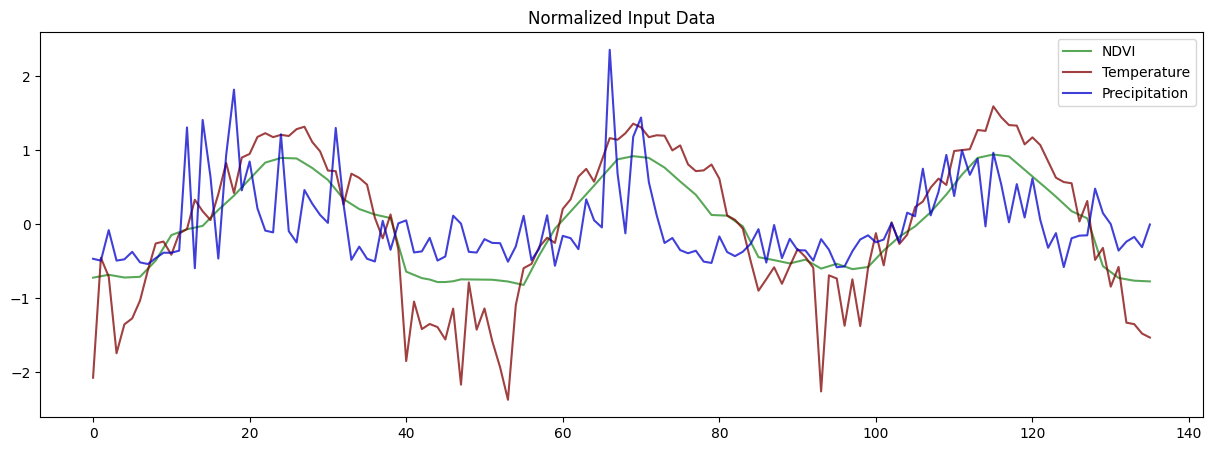

In [10]:
data_arr = convlstm.load_data()

In [12]:
inputs = data_arr[:, :, :, 1:]
outputs = data_arr[:, :, :, 0]
inputs.shape, outputs.shape

((136, 1422, 854, 2), (136, 1422, 854))

In [13]:
(
    inputs_train,
    outputs_train,
    inputs_val,
    outputs_val,
    inputs_test,
    outputs_test,
) = convlstm.split_data(inputs, outputs)

Input train shape: (68, 1422, 854, 2)
Output train shape: (68, 1422, 854)
Input val shape: (34, 1422, 854, 2)
Output val shape: (34, 1422, 854)
Input test shape: (34, 1422, 854, 2)
Output test shape: (34, 1422, 854)


In [14]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.layers import ConvLSTM2D, Conv2D

# from keras.layers.convolutional import Conv2D

import matplotlib.pyplot as plt

In [20]:
mc = keras.callbacks.ModelCheckpoint(
    "modelsPerEpoch/weights{epoch:06d}.hdf5", save_weights_only=False, period=1
)

input = keras.layers.Input(
    shape=(None, *list(inputs_train.shape)[1:]), dtype="float32", name="input"
)

hidden = ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    # data_format="channels_first",
)(input)

output = Conv2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    activation="sigmoid",
    kernel_initializer="glorot_uniform",
    # data_format="channels_first",
    name="output",
)(hidden)

sgd = keras.optimizers.SGD(lr=0.002, momentum=0.0, nesterov=False)  # decay=0.0,

model = keras.Model(inputs=input, outputs=output)

model.compile(
    optimizer=sgd,
    loss="mean_squared_error",
    metrics=[
        keras.metrics.mse,
        keras.metrics.RootMeanSquaredError(),
    ],  # convlstm.root_mean_squared_error],
)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 1422, 854,  0         
                              2)]                                
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 1422, 854,   28864     
                             16)                                 
                                                                 
 output (Conv2D)             (None, None, 1422, 854,   17        
                             1)                                  
                                                                 
Total params: 28,881
Trainable params: 28,881
Non-trainable params: 0
_________________________________________________________________


In [22]:
training_data = model.fit(
    np.expand_dims(inputs_train, 0),
    np.expand_dims(outputs_train, 0),
    epochs=5,
    batch_size=1,
    validation_data=(np.expand_dims(inputs_val, 0), np.expand_dims(outputs_val, 0)),
    # verbose=1,
    callbacks=[mc, decay_learner],
    # shuffle=True,
)

np.save("training_loss", training_data.history["root_mean_squared_error"])
np.save("validation_loss", training_data.history["val_root_mean_squared_error"])

plt.plot(training_data.history["root_mean_squared_error"])
plt.plot(training_data.history["val_root_mean_squared_error"])

plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validate"], loc="upper left")
plt.show()

Epoch 1/5


In [ ]:
keras.backend.count

In [ ]:
score = model.evaluate(inputs_test, outputs_test, batch_size=1)
predictions = model.predict(inputs_test)

np.save("test_arrays", predictions)
print(score)